# Image Preprocessing & Augmentation

**Segmentation**  
We experimented with background subtraction / color-based segmentation to isolate the hand from the background. However, the images in our dataset already have clean backgrounds with minimal noise. Therefore, the segmented images looked very similar to the originals, and segmentation did not add significant benefit for training.

---

**Normalization**  
We applied normalization to scale pixel values from the range [0, 255] down to [0, 1]. This ensures more stable training and faster convergence.

---

**Data Augmentation**  
We applied data augmentation To increase dataset variability and reduce overfitting by creating modified versions of training images so the model can generalize better to unseen data.  

We used the following transformations:  
- **Random Flip (horizontal):** Helps the model learn that left/right orientations of the hand are equally valid.  
- **Random Rotation (0.1):** Introduces slight rotations to simulate natural variation in how hands appear.  
- **Random Zoom (0.1):** Covers different hand sizes or distances from the camera.  
- **Random Translation (0.1, 0.1):** Allows the model to handle shifts in hand position.  
- **Random Contrast (0.1):** Teaches the model to be able to handle different lighting conditions.

In [2]:
import tensorflow
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
import random
import mediapipe as mp

In [ ]:
def compare_segmented_images(original_split_path, segmented_split_path, num_samples=5):
    """
    Display random before/after segmentation image pairs side-by-side.

    Parameters:
    - original_split_path: path to the split folder of the original dataset (e.g., train/val/test)
    - segmented_split_path: path to the split folder of the segmented dataset
    - num_samples: number of image pairs to display
    """

    # Validate directories
    if not os.path.exists(original_split_path) or not os.path.exists(segmented_split_path):
        raise ValueError("Invalid paths. Check that both folders exist.")

    # Get all class folders
    class_names = [cls for cls in os.listdir(original_split_path)
                   if os.path.isdir(os.path.join(original_split_path, cls))]

    if not class_names:
        raise ValueError(f"No class folders found in {original_split_path}")

    # Choose random class
    chosen_class = random.choice(class_names)
    print(f"Selected class: {chosen_class}")

    # List all images from that class
    orig_class_path = os.path.join(original_split_path, chosen_class)
    seg_class_path = os.path.join(segmented_split_path, chosen_class)

    orig_images = os.listdir(orig_class_path)
    seg_images = os.listdir(seg_class_path)

    # Find common filenames
    common_files = list(set(orig_images) & set(seg_images))
    if not common_files:
        raise ValueError(f"No common image filenames found in {chosen_class}.")

    # Randomly select N samples
    selected_files = random.sample(common_files, min(num_samples, len(common_files)))


 # Create a figure with 2 rows (Originals on top, Segmented below)
    fig, axes = plt.subplots(2, num_samples, figsize=(4 * num_samples, 8))
    fig.suptitle(f"Original vs Segmented Images ({chosen_class})", fontsize=14)

    for i, fname in enumerate(selected_files):
        orig_path = os.path.join(orig_class_path, fname)
        seg_path = os.path.join(seg_class_path, fname)

        orig_img = cv2.imread(orig_path)
        seg_img = cv2.imread(seg_path)

        if orig_img is None or seg_img is None:
            print(f"Skipping unreadable image: {fname}")
            continue

        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        seg_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)

        # Top row: Original
        axes[0, i].imshow(orig_img)
        axes[0, i].set_title(f"Original ({fname})", fontsize=10)
        axes[0, i].axis("off")

        # Bottom row: Segmented
        axes[1, i].imshow(seg_img)
        axes[1, i].set_title("Segmented")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

In [ ]:
train_dir = "/Dataset/train"
val_dir   = "/Dataset/val"
test_dir  = "/Dataset/test"

train_dir_seg = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset_segmented/train"
val_dir_seg   = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset_segmented/val"
test_dir_seg  = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset_segmented/test"

Selected class: 05_thumb


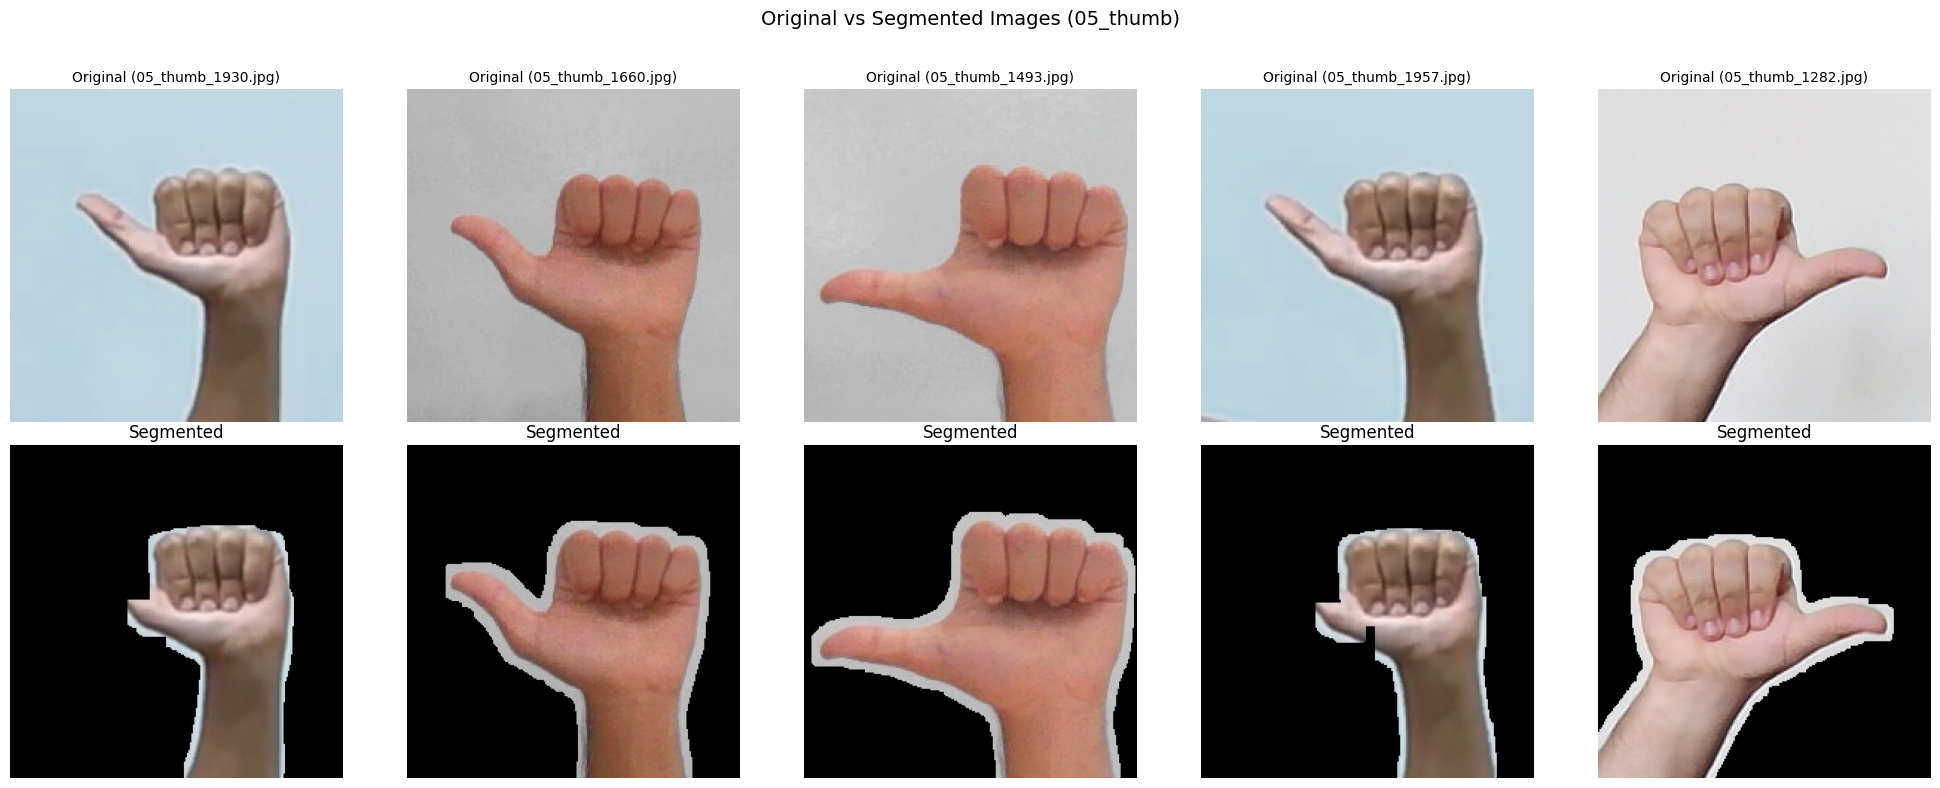

In [ ]:
compare_segmented_images(
    original_split_path = train_dir,
    segmented_split_path=train_dir_seg,
    num_samples=5
)

In [ ]:
# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=256,
    seed=111,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=256,
    seed=111,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=256,
    seed=111,
    shuffle=False
)

Found 18739 files belonging to 10 classes.
Found 4012 files belonging to 10 classes.
Found 4026 files belonging to 10 classes.


In [ ]:
# Define the Normalization Layer
normalization_layer = layers.Rescaling(1./255)

In [ ]:
# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])

In [ ]:
# Apply preprocessing to The Images
train_data = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y))
val_data   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_data  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Draw Landmarks on the hands

In [ ]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
mp_drawing = mp.solutions.drawing_utils

In [ ]:
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

base_path = "Dataset"
split_data = {
    'train': (X_train, y_train),
    'val': (X_val, y_val),
    'test': (X_test, y_test)
}

for split, (X, y) in split_data.items():
    split_path = os.path.join(base_path, split)
    if not os.path.isdir(split_path):
        continue
    print(f"Processing {split} data...")
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = hands.process(img_rgb)
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    landmark_points = []
                    for lm in hand_landmarks.landmark:
                        landmark_points.extend([lm.x, lm.y, lm.z])
                    # Normalize by wrist position
                    pts = np.array(landmark_points)
                    wrist_x, wrist_y = pts[0], pts[1]
                    pts[0::3] -= wrist_x
                    pts[1::3] -= wrist_y
                    X.append(pts)
                    y.append(label)

Processing train data...


Processing val data...
Processing test data...
Processing test data...


In [ ]:
# Convert to numpy arrays and save data
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Save the landmarks and labels
print("Saving landmarks and labels...")
np.savez('data/landmarks_train.npz', X=X_train, y=y_train)
np.savez('data/landmarks_val.npz', X=X_val, y=y_val)
np.savez('data/landmarks_test.npz', X=X_test, y=y_test)

print("Train:", X_train.shape, len(y_train))
print("Val:", X_val.shape, len(y_val))
print("Test:", X_test.shape, len(y_test))

print("\nData saved successfully! Next time you can skip the extraction by running the next cell.")

Saving landmarks and labels...
Train: (16401, 63) 16401
Val: (3526, 63) 3526
Test: (3514, 63) 3514

Data saved successfully! Next time you can skip the extraction by running the next cell.


# Load Pre-extracted Landmarks (Optional)

If you have already extracted and saved the landmarks, you can load them directly by running this cell instead of extracting them again.

In [5]:
# Load the saved landmarks and labels
print("Loading saved landmarks...")
train_data = np.load('data/landmarks_train.npz')
val_data = np.load('data/landmarks_val.npz')
test_data = np.load('data/landmarks_test.npz')

X_train, y_train = train_data['X'], train_data['y']
X_val, y_val = val_data['X'], val_data['y']
X_test, y_test = test_data['X'], test_data['y']

print("Train:", X_train.shape, len(y_train))
print("Val:", X_val.shape, len(y_val))
print("Test:", X_test.shape, len(y_test))

Loading saved landmarks...
Train: (16401, 63) 16401
Val: (3526, 63) 3526
Test: (3514, 63) 3514


In [6]:
print(y_train)

['01_palm' '01_palm' '01_palm' ... '10_down' '10_down' '10_down']


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Convert to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Save the landmarks and labels
print("Saving landmarks and labels...")
np.savez('data/landmarks_train.npz', X=X_train, y=y_train)
np.savez('data/landmarks_val.npz', X=X_val, y=y_val)
np.savez('data/landmarks_test.npz', X=X_test, y=y_test)

print("Train:", X_train.shape, len(y_train))
print("Val:", X_val.shape, len(y_val))
print("Test:", X_test.shape, len(y_test))

Saving landmarks and labels...
Train: (16401, 63) 16401
Val: (3526, 63) 3526
Test: (3514, 63) 3514


In [ ]:
# --- Reshape flattened landmark arrays, normalize, scale, and save ---
import numpy as np, os, pickle
from sklearn.preprocessing import StandardScaler

# Expect X_train, X_val, X_test, y_train, y_val, y_test already in memory
print("Input shapes (flattened):", X_train.shape, X_val.shape, X_test.shape)

def unflatten_landmarks(X_flat):
    """
    Convert X_flat (N, F) -> (N, 21, C)
    where F==63 -> C=3, F==42 -> C=2
    """
    X_flat = np.array(X_flat)
    if X_flat.ndim != 2:
        raise ValueError("Expected flattened 2D array (N, F), got shape: " + str(X_flat.shape))
    N, F = X_flat.shape
    if F == 63:
        C = 3
    elif F == 42:
        C = 2
    else:
        raise ValueError("Unexpected feature size F. Expected 63 or 42, got F=" + str(F))
    return X_flat.reshape(N, 21, C)

# Reuse normalization functions (same logic as before)
def normalize_frame(lm, origin_idx=0, scale_method='max_dist', rotate=True, eps=1e-8):
    lm = np.array(lm, dtype=np.float32).reshape(-1, lm.shape[-1])
    origin = lm[origin_idx].copy()
    lm = lm - origin
    # scale
    if scale_method == 'max_dist':
        dists = np.linalg.norm(lm, axis=1)
        scale = dists.max()
    elif scale_method == 'wrist_to_middle':
        scale = np.linalg.norm(lm[9])
    elif scale_method == 'bbox':
        scale = np.linalg.norm(lm.max(axis=0) - lm.min(axis=0))
    else:
        raise ValueError("unknown scale_method")
    scale = max(scale, eps)
    lm = lm / scale
    # rotate in XY if possible
    if rotate and lm.shape[1] >= 2:
        v = lm[9,:2]
        angle = np.arctan2(v[0], v[1])
        c = np.cos(-angle); s = np.sin(-angle)
        R = np.array([[c, -s],[s, c]], dtype=np.float32)
        lm[:,:2] = lm[:,:2] @ R.T
    return lm

def normalize_dataset(X, per_sequence=False, origin_idx=0, scale_method='max_dist', rotate=True):
    X = np.array(X, dtype=np.float32)
    if X.ndim == 3:
        N,_,_ = X.shape
        out = np.zeros_like(X)
        for i in range(N):
            out[i] = normalize_frame(X[i], origin_idx=origin_idx, scale_method=scale_method, rotate=rotate)
        return out
    else:
        raise ValueError("normalize_dataset expects X of shape (N,21,C). Got: " + str(X.shape))

def flatten_back(X):
    # X: (N,21,C) -> (N, F)
    N,_,C = X.shape
    return X.reshape(N, 21*C)

# 1) Unflatten if needed
X_train_lm = X_train if (X_train.ndim==3 and X_train.shape[1]==21) else unflatten_landmarks(X_train)
X_val_lm   = X_val   if (X_val.ndim==3 and X_val.shape[1]==21) else unflatten_landmarks(X_val)
X_test_lm  = X_test  if (X_test.ndim==3 and X_test.shape[1]==21) else unflatten_landmarks(X_test)

print("After unflattening shapes:", X_train_lm.shape, X_val_lm.shape, X_test_lm.shape)
# 2) Normalize (per-frame)
X_train_norm = normalize_dataset(X_train_lm, per_sequence=False, origin_idx=0, scale_method='max_dist', rotate=True)
X_val_norm   = normalize_dataset(X_val_lm,   per_sequence=False, origin_idx=0, scale_method='max_dist', rotate=True)
X_test_norm  = normalize_dataset(X_test_lm,  per_sequence=False, origin_idx=0, scale_method='max_dist', rotate=True)
print("After normalization shapes:", X_train_norm.shape, X_val_norm.shape, X_test_norm.shape)

# 3) Flatten for scaler (back to (N, F))
X_train_flat = flatten_back(X_train_norm)
X_val_flat   = flatten_back(X_val_norm)
X_test_flat  = flatten_back(X_test_norm)
print("Flattened normalized shapes:", X_train_flat.shape, X_val_flat.shape, X_test_flat.shape)

# 4) Fit StandardScaler on training flattened features only
scaler = StandardScaler()
scaler.fit(X_train_flat)
X_train_scaled = scaler.transform(X_train_flat)
X_val_scaled   = scaler.transform(X_val_flat)
X_test_scaled  = scaler.transform(X_test_flat)
print("Scaled shapes:", X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)

# 5) Save normalized data and scaler
out_dir = "normalized_landmarks/"
os.makedirs(out_dir, exist_ok=True)
np.savez_compressed(os.path.join(out_dir, 'landmarks_train_normalized.npz'), X=X_train_scaled, y=y_train)
np.savez_compressed(os.path.join(out_dir, 'landmarks_val_normalized.npz'), X=X_val_scaled, y=y_val)
np.savez_compressed(os.path.join(out_dir, 'landmarks_test_normalized.npz'), X=X_test_scaled, y=y_test)
with open(os.path.join(out_dir, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

print("Saved normalized data + scaler to", out_dir)

# 6) OPTIONALLY: Replace original training variables (so your existing training cell can run without editing)
# Uncomment the lines below if you want the notebook to automatically use normalized arrays from here on:
X_train = X_train_scaled
X_val   = X_val_scaled
X_test  = X_test_scaled
# If you uncomment those lines, they become (N, F) flattened arrays ready for MLP/ML model.
# If your model expects shape (N, 21, 3), reshape with:
# X_train = X_train_scaled.reshape(-1, 21, X_train_lm.shape[2])



Input shapes (flattened): (16401, 63) (3526, 63) (3514, 63)
After unflattening shapes: (16401, 21, 3) (3526, 21, 3) (3514, 21, 3)
After normalization shapes: (16401, 21, 3) (3526, 21, 3) (3514, 21, 3)
Flattened normalized shapes: (16401, 63) (3526, 63) (3514, 63)
Scaled shapes: (16401, 63) (3526, 63) (3514, 63)
Saved normalized data + scaler to normalized_landmarks/


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Fit on all labels to ensure same encoding across sets
all_labels = np.concatenate([y_train, y_val, y_test])
le.fit(all_labels)

y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

In [ ]:
model = Sequential([
    Dense(256, input_shape=(63,)),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(len(le.classes_), activation='softmax')
])
model.summary()

/home/zoma/anaconda3/envs/depi/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,794 (495.29 KB)

 Trainable params: 125,386 (489.79 KB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
from keras.callbacks import ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val_cat),
    callbacks=callbacks,
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"\nTest accuracy: {test_acc:.4f}")

Epoch 1/50


2025-11-19 20:49:00.796313: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fa6d4017ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-19 20:49:00.796323: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-11-19 20:49:00.822915: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-19 20:49:01.005070: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-19 20:49:01.130114: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-19 20:49:01.

152/513 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5944 - loss: 1.2946

I0000 00:00:1763578144.927485  903644 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


503/513 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7670 - loss: 0.7529  

2025-11-19 20:49:05.726562: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-19 20:49:05.726581: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-19 20:49:05.726588: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-19 20:49:05.726592: I external/l

513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7693 - loss: 0.7455

513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8876 - loss: 0.3725 - val_accuracy: 0.9810 - val_loss: 0.0565 - learning_rate: 0.0010
Epoch 2/50
511/513 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.9629 - loss: 0.1222

513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9654 - loss: 0.1128 - val_accuracy: 0.9938 - val_loss: 0.0220 - learning_rate: 0.0010
Epoch 3/50
485/513 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.9779 - loss: 0.0794

513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9768 - loss: 0.0781 - val_accuracy: 0.9966 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 4/50
472/513 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.9821 - loss: 0.0635

513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9820 - loss: 0.0585 - val_accuracy: 0.9960 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 5/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9853 - loss: 0.0508 - val_accuracy: 0.9946 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 6/50
484/513 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.9839 - loss: 0.0520

513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9840 - loss: 0.0509 - val_accuracy: 0.9969 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 7/50
466/513 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.9829 - loss: 0.0520

513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9862 - loss: 0.0435 - val_accuracy: 0.9977 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 8/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9879 - loss: 0.0391 - val_accuracy: 0.9977 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 9/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9892 - loss: 0.0362 - val_accuracy: 0.9969 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 10/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9883 - loss: 0.0391 - val_accuracy: 0.9969 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 11/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9869 - loss: 0.0426 - val_accuracy: 0.9932 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 12/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9899 - loss: 0.0351 - val_accuracy: 0.9974 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 13/50
485/513 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.9942 - loss: 0.0214

513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9950 - loss: 0.0199 - val_accuracy: 0.9983 - val_loss: 0.0083 - learning_rate: 5.0000e-04
Epoch 14/50
507/513 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0134

513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9967 - loss: 0.0135 - val_accuracy: 0.9989 - val_loss: 0.0072 - learning_rate: 5.0000e-04
Epoch 15/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9953 - loss: 0.0161 - val_accuracy: 0.9989 - val_loss: 0.0082 - learning_rate: 5.0000e-04
Epoch 16/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9944 - loss: 0.0180 - val_accuracy: 0.9980 - val_loss: 0.0121 - learning_rate: 5.0000e-04
Epoch 17/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9953 - loss: 0.0174 - val_accuracy: 0.9972 - val_loss: 0.0102 - learning_rate: 5.0000e-04
Epoch 18/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9944 - loss: 0.0177 - val_accuracy: 0.9983 - val_loss: 0.0074 - learning_rate: 5.0000e-04
Epoch 19/50
505/513 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0185

513/513 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9943 - loss: 0.0184 - val_accuracy: 0.9989 - val_loss: 0.0060 - learning_rate: 5.0000e-04
Epoch 20/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9955 - loss: 0.0153 - val_accuracy: 0.9986 - val_loss: 0.0087 - learning_rate: 5.0000e-04
Epoch 21/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9952 - loss: 0.0139 - val_accuracy: 0.9983 - val_loss: 0.0078 - learning_rate: 5.0000e-04
Epoch 22/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9963 - loss: 0.0128 - val_accuracy: 0.9977 - val_loss: 0.0115 - learning_rate: 5.0000e-04
Epoch 23/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9956 - loss: 0.0144 - val_accuracy: 0.9989 - val_loss: 0.0064 - learning_rate: 5.0000e-04
Epoch 24/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9954 - loss: 0.0156 - val_accuracy: 0.9969 - val_loss: 0.0132 - learning_rate: 5.0000e-04
Epoch 25/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.997

2025-11-19 20:49:35.824474: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-19 20:49:35.824515: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-19 20:49:35.824536: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-19 20:49:35.824550: I external/l

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9983 - loss: 0.0116

Test accuracy: 0.9983


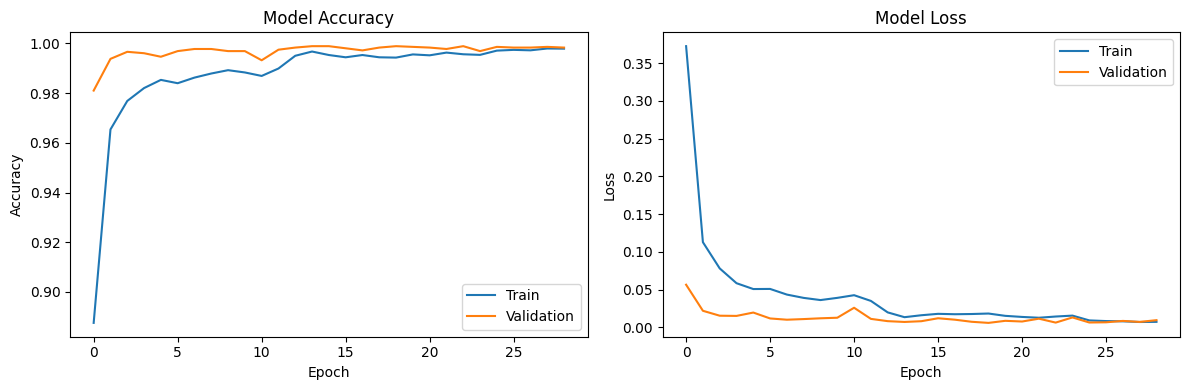

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes,
                          target_names=le.classes_))


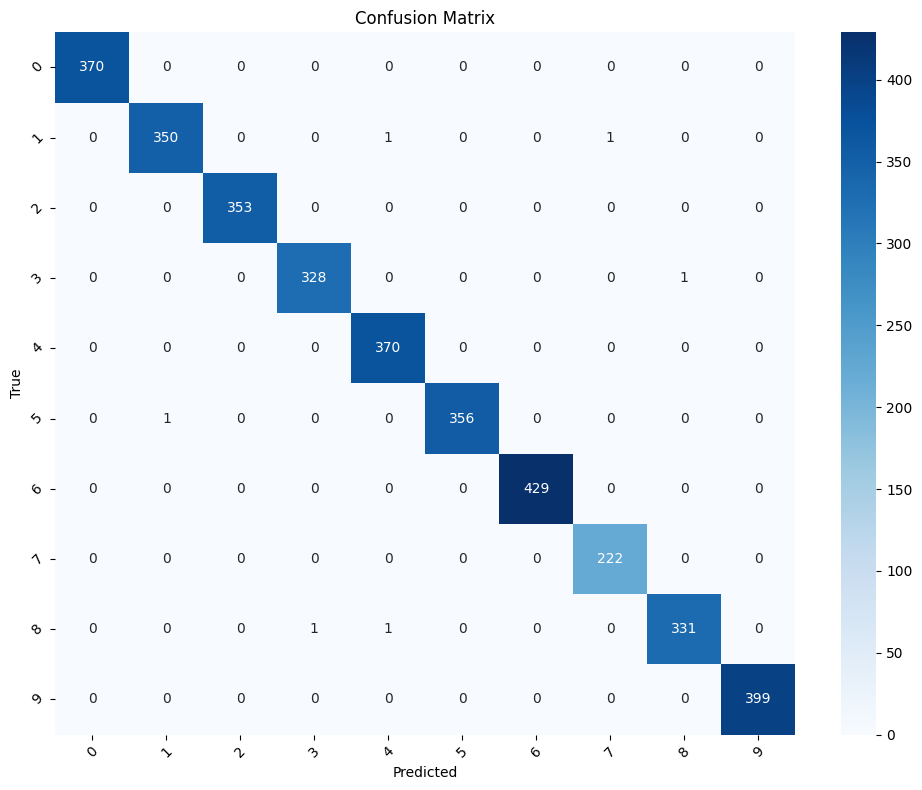

In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pickle
with open('hand_gesture_norm_model.pkl', 'wb') as f:
    pickle.dump((model, le), f)
